In [1]:
# Importing the necessary libraries

import numpy as np
from numpy import expand_dims
import pandas as pd
import os
import json
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

In [4]:
# Unzipping dataset

!unzip shipsnet.json.zip

Archive:  shipsnet.json.zip
replace shipsnet.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
# Put dataset in pandas DataFrame

with open('/content/shipsnet.json') as data_file:
    dataset = json.load(data_file)
ships = pd.DataFrame(dataset)
ships.head()

,data,labels,locations,scene_ids
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1,"[-118.2254694333423, 33.73803725920789]",20180708_180909_0f47
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1,"[-122.33222866289329, 37.7491755586813]",20170705_180816_103e
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1,"[-118.14283073363218, 33.736016066914175]",20180712_211331_0f06
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1,"[-122.34784341495181, 37.76648707436548]",20170609_180756_103a
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1,"[-122.34852408322172, 37.75878462398653]",20170515_180653_1007


In [5]:
# Data and Labels columns are extracted (only need these two columns)

ships = ships[['data', 'labels']]
ships.head()

,data,labels
0,"[82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...",1
1,"[76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...",1
2,"[125, 127, 129, 130, 126, 125, 129, 133, 132, ...",1
3,"[102, 99, 113, 106, 96, 102, 105, 105, 103, 10...",1
4,"[78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...",1


In [6]:
# Check the number of ship and not ship images

ship_images = ships['labels'].value_counts()[0]
not_ship_images = ships['labels'].value_counts()[1]
print("Number of ship images: {}".format(ship_images), "\n")
print("Number of not ship images: {}".format(not_ship_images))

Number of ship images: 3000 

Number of not ship images: 1000


In [7]:
# Converting data and labels into NumPy arrays of type uint8

x = np.array(dataset['data']).astype('uint8')
y = np.array(dataset['labels']).astype('uint8')

In [8]:
# Image data is reshaped and transposed to match the input shape expected by the model

x_reshaped = x.reshape([-1, 3, 80, 80]).transpose([0, 2, 3, 1])
x_reshaped.shape

(4000, 80, 80, 3)

In [9]:
# Function used to perform image processing

def add_padding(x_reshaped, target_size):
  padded_images = []
  for image in x_reshaped:
    height, width, channels = image.shape

    pad_height = max(target_size[0] - height, 0)
    pad_width = max(target_size[1] - width, 0)

    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left

    padded_image = np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right), (0,0)), mode='constant')
    padded_images.append(padded_image)
  return np.array(padded_images)

In [10]:
# Image processing performed

target_size = (224, 224, 3)
padded_images = add_padding(x_reshaped, target_size)
print(padded_images.shape)

(4000, 224, 224, 3)


In [11]:
# Pixel values are normalized to be between 0 and 1

x_reshaped = padded_images/255

In [12]:
x_reshaped.shape

(4000, 224, 224, 3)

In [13]:
y.shape

(4000,)

In [15]:
# Labels are one-hot encoded to prepare for use of categorical crossentropy

y_reshaped = to_categorical(y, num_classes=2)
y_reshaped.shape

(4000, 2)

In [16]:
# Dataset is split into training, validation, and testing sets

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_reshaped, y_reshaped, test_size=0.20, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_1, y_train_1, test_size=0.25, random_state=42)


In [17]:
# Installing efficientnet for EfficientNETB0 model

!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.8 MB/s eta 0:00:00


In [18]:
# Import necessary modules from Keras and EfficientNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.regularizers import l2

# Initialize base model without final fully connected layer so we can add our own classification layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Setting number of classes for classification task
n_classes = 2
# Set all layers in base model to be trainable
base_model.trainable = True

# Set the last 10 layers of the base model to be trainable (fine-tuning)
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Define new model using Sequential API
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) # reduces the spatial dimensions of the input
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5)) # helps prevent overfitting
model.add(Dense(n_classes, activation='softmax')) # outputs a probability distribution over the classes

# Complie the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

16804768/16804768 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                81984     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                         

In [19]:
from keras import callbacks
import cv2

# Function to apply a series of random transformations to an image
def apply_transform(image):
  shear_range = 20
  translation_range = 0.2
  zoom_range = [0.8, 1.2]
  rotation_range = 20

  rows, cols, _ = image.shape
  shear = np.random.randint(-shear_range, shear_range)
  translation_x = np.random.randint(-translation_range * cols, translation_range * cols)
  translation_y = np.random.randint(-translation_range * rows, translation_range * rows)
  zoom = np.random.uniform(zoom_range[0], zoom_range[1])
  rotation = np.random.randint(-rotation_range, rotation_range)

  matrix = cv2.getRotationMatrix2D((cols // 2, rows // 2), rotation, zoom)
  matrix[:, 2] += (translation_x, translation_y)

  shear_matrix = np.array([[1, abs(np.tan(np.deg2rad(shear))), 0], [0, 1, 0]])

  if shear > 0:
    image = cv2.warpAffine(image, shear_matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)
  else:
    image = cv2.warpAffine(image, matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)

  return cv2.warpAffine(image, matrix, (cols, rows), borderMode=cv2.BORDER_REFLECT_101)

aug = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    preprocessing_function = apply_transform)


from tensorflow.keras.callbacks import LearningRateScheduler

# Function to control learning rate during training
def lr_schedule(epoch):
  initial_lr = 0.001
  if epoch < 5:
    return initial_lr
  else:
    return initial_lr / 100

lr_scheduler = LearningRateScheduler(lr_schedule)

batch_size = 25
epochs = 8

# Number of batches of samples that will constitute an epoch
steps_per_epoch = len(x_train) // batch_size

# Trian the model
history = model.fit(aug.flow(x_train, y_train, batch_size = batch_size),
                    steps_per_epoch = steps_per_epoch,
                    epochs = epochs,
                    validation_data = (x_test_1, y_test_1),
                    callbacks = [lr_scheduler])


Epoch 1/8
96/96 [==============================] - 95s 934ms/step - loss: 0.9586 - accuracy: 0.8763 - val_loss: 0.4349 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 2/8
96/96 [==============================] - 87s 901ms/step - loss: 0.4019 - accuracy: 0.9217 - val_loss: 0.2508 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 3/8
96/96 [==============================] - 84s 878ms/step - loss: 0.2771 - accuracy: 0.9292 - val_loss: 0.1354 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/8
96/96 [==============================] - 87s 901ms/step - loss: 0.2077 - accuracy: 0.9396 - val_loss: 0.1193 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 5/8
96/96 [==============================] - 93s 965ms/step - loss: 0.1878 - accuracy: 0.9383 - val_loss: 0.2043 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 6/8
96/96 [==============================] - 88s 921ms/step - loss: 0.1866 - accuracy: 0.9417 - val_loss: 0.1106 - val_accuracy: 0.9787 - lr: 1.0000e-05
Epoch 7/8
96/96 [==============================] - 88s 919ms/step 

In [20]:
# Model is evaluated on the test set

model.evaluate(x_test_1, y_test_1)

25/25 [==============================] - 23s 940ms/step - loss: 0.0990 - accuracy: 0.9825


[0.09899012744426727, 0.9825000166893005]

25/25 [==============================] - 20s 751ms/step

Test Accuracy Score :  0.9825 



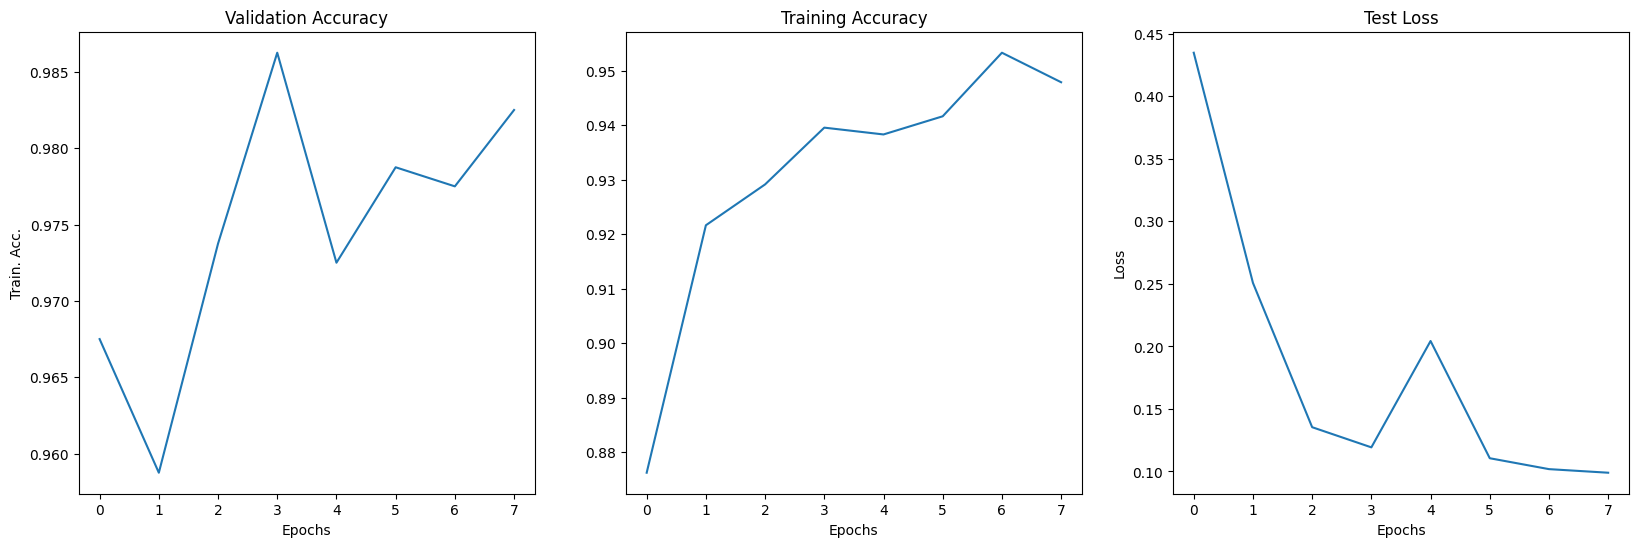

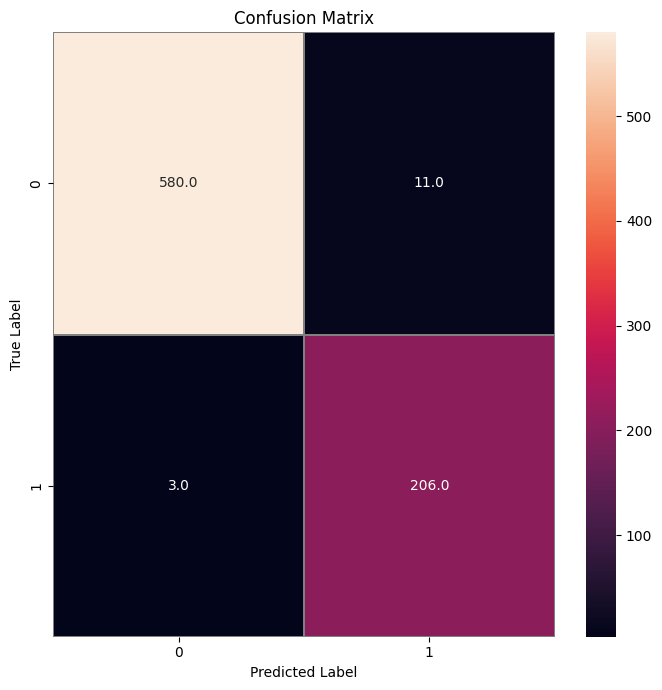

In [21]:
from sklearn import metrics
import seaborn as sns

# Generate predictions for the test set
Y_pred = model.predict(x_test_1)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test_1,axis = 1)

# Print accuracy score
print("\n""Test Accuracy Score : ",metrics.accuracy_score(Y_true, Y_pred_classes),"\n")

# Plots to show training history
fig, axis = plt.subplots(1, 3, figsize=(20,6))
axis[0].plot(history.history['val_accuracy'], label='val_acc')
axis[0].set_title("Validation Accuracy")
axis[0].set_xlabel("Epochs")
axis[0].set_ylabel("Val. Acc.")
axis[1].plot(history.history['accuracy'], label='acc')
axis[1].set_title("Training Accuracy")
axis[1].set_xlabel("Epochs")
axis[0].set_ylabel("Train. Acc.")
axis[2].plot(history.history['val_loss'], label='val_loss')
axis[2].set_title("Test Loss")
axis[2].set_xlabel("Epochs")
axis[2].set_ylabel("Loss")

plt.show()

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
# Plot the confusion matrix
f,ax = plt.subplots(figsize=(7, 7))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()

plt.show()

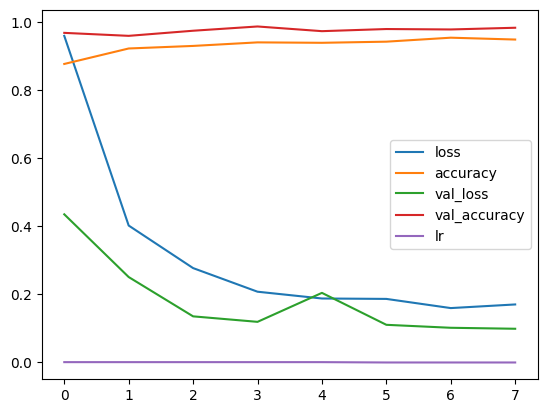

In [22]:
pd.DataFrame(history.history).plot();

In [23]:
# Save the model

model.save('ShipDetection_8epochs.h5')